# 0. Importing Basic Libraries, Definitions & Constants

In [39]:
import numpy as np
import pandas as pd
from ggplot import *

In [2]:
import csv
import re
import jieba.analyse
import random
import warnings
from bs4 import BeautifulSoup
from collections import defaultdict

In [3]:
random_seed = 64 #Can be anyvalue - but it is important to set one to keep training/holdout set constant
relevance_cutoff = 1.8 # required TFIDF value to be included in the relevant token set
occurrent_cutoff = 50 #required document occurrence to be included in the relevant token set
test_share = 0.4 #share of the holdout sample vs the training sample
warnings.filterwarnings('ignore')



# 1. Preprocessing
## 1.1 Loading Training Data (For Input Vectors)

In [4]:
training_df = pd.read_csv('offsite-test-material/offsite-tagging-training-set.csv', encoding='utf8')
training_df.index = training_df['id']
training_df.head()

,id,tags,text
id,,,
3443,3443,足球,利物浦重賽擊敗乙組仔 英足盃過關 英格蘭足總盃第三圈今晨重賽，貴為英超勁旅的利物浦上場被乙組...
76056,76056,足球,【中超】恒大「暴力戰」絕殺國安 楊智反重力插水惹爭議（有片） 中超首輪賽事重頭戲，廣州恒大主...
93405,93405,足球,【歐霸決賽】阿積士控球率起腳佔優 隊長卡拉臣輸波不服氣 阿積士以歐洲主要決賽最年輕、平均22...
26767,26767,足球,【歐國盃】韋莫斯澄清更衣室未內訌 盼以團結力量挫愛爾蘭 今晚3場直播\r\r\nE組｜比利時...
20843,20843,梁振英,王維基參選 點解？ 王維基在宣布有意出選的記者會上，打出ABC，Anyone But CY的...


In [5]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html5lib') #remove HTML tokens
    text_only = soup.get_text() 
    text_normal_newline = re.sub("\n\n+", "\n", text_only)
    text_normal_space = re.sub("\s\s+", " ", text_normal_newline)
    return text_normal_space

In [6]:
training_df['text_clean'] = training_df.apply(lambda _: remove_html(_['text']), axis=1)
training_df['clean_length'] = training_df.apply(lambda _: len(_['text_clean']), axis=1)
training_df.head()

,id,tags,text,text_clean,clean_length
id,,,,,
3443,3443,足球,利物浦重賽擊敗乙組仔 英足盃過關 英格蘭足總盃第三圈今晨重賽，貴為英超勁旅的利物浦上場被乙組...,利物浦重賽擊敗乙組仔 英足盃過關 英格蘭足總盃第三圈今晨重賽，貴為英超勁旅的利物浦上場被乙組...,369
76056,76056,足球,【中超】恒大「暴力戰」絕殺國安 楊智反重力插水惹爭議（有片） 中超首輪賽事重頭戲，廣州恒大主...,【中超】恒大「暴力戰」絕殺國安 楊智反重力插水惹爭議（有片） 中超首輪賽事重頭戲，廣州恒大主...,631
93405,93405,足球,【歐霸決賽】阿積士控球率起腳佔優 隊長卡拉臣輸波不服氣 阿積士以歐洲主要決賽最年輕、平均22...,【歐霸決賽】阿積士控球率起腳佔優 隊長卡拉臣輸波不服氣 阿積士以歐洲主要決賽最年輕、平均22...,948
26767,26767,足球,【歐國盃】韋莫斯澄清更衣室未內訌 盼以團結力量挫愛爾蘭 今晚3場直播\r\r\nE組｜比利時...,【歐國盃】韋莫斯澄清更衣室未內訌 盼以團結力量挫愛爾蘭 今晚3場直播\nE組｜比利時Vs愛爾...,770
20843,20843,梁振英,王維基參選 點解？ 王維基在宣布有意出選的記者會上，打出ABC，Anyone But CY的...,王維基參選 點解？ 王維基在宣布有意出選的記者會上，打出ABC，Anyone But CY的...,1239


In [7]:
def process_group(row):
    return pd.Series(dict(char_cnt=row['clean_length'].sum(), record_cnt=row.clean_length.count()))
labels_df = pd.DataFrame(training_df.groupby(['tags']).apply(process_group))
labels_df['label_id'] = pd.Categorical(labels_df.index).codes
label_dict = {a: b.label_id for a, b in labels_df.iterrows()}
label_id_dict = {b.label_id: a for a, b in labels_df.iterrows()}
labels = list(label_dict.keys())
labels_df.head()


,char_cnt,record_cnt,label_id
tags,,,
梁振英,868598,929,0
美國大選,972470,842,1
足球,1672172,2123,2


## 1.2 Loading Data (For Frequency Analysis)

In [8]:
text_dict = defaultdict(list)
with open('offsite-test-material/offsite-tagging-training-set.csv', 'r', encoding='utf8') as f:
    file_reader = csv.reader(f, delimiter=',', quotechar='"')
    next(file_reader)
    for row in file_reader:
        text_dict[row[1]].append(remove_html(row[2]))

fulltext_dict = {k: '\n'.join([_ for _ in v]) for k, v in text_dict.items()}

In [9]:
print('Found the following categories:\n{}'.format('\n'.join(['{}: {} fragments with {} characters'
                                                               .format(k, len(text_dict[k]), len(fulltext_dict[k]))
                                                               for k in text_dict.keys() ])))

Found the following categories:
足球: 2123 fragments with 1674294 characters
梁振英: 929 fragments with 869526 characters
美國大選: 842 fragments with 973311 characters


This means that we have twice the frequency of articles related to soccer than to either the outgoing CE or US elections. This is a bit tricky in terms of maximum TF-IDF

## 1.2 Selecting most relevant tokens
I am building a TD-IDF-esque model, for which I will select the most 'relevant' tokens as features. Relevance here is defined as the highest ratio of frequency in the relevant 'term' over the frequency in the overall 'document'. A 'term' here is the union of all segments that belong to a single categroy. The document is the union of all segments

In [10]:
#dictionary for occurrence of short tokens in each classified doc
labeldicts_short = {_: (defaultdict(float), 0) for _ in labels} 
#dictionary for occurrence of long tokens in each classified doc
labeldicts_long = {_: (defaultdict(float), 0) for _ in labels} 
# dictionary for occurrence of short tokens in the whole document
docdict_short = defaultdict(float), 0 
# dictionary for occurrence of long tokens in the whole document
docdict_long = defaultdict(float), 0


In [11]:
# Counting token frequency
training_clean = list()
for label, combined_text in fulltext_dict.items():
    short_tokens = jieba.cut(combined_text, cut_all=True)
    for token in short_tokens:
        labeldicts_short[label][0][token] += 1
        docdict_short[0][token] += 1
        
    long_tokens = jieba.cut(combined_text, cut_all=False)
    for token in long_tokens:
        labeldicts_long[label][0][token] += 1
        docdict_long[0][token] += 1
        
        


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/9d/qql6_x6575d88_7f44mgptw40000gp/T/jieba.cache
Loading model cost 0.864 seconds.
Prefix dict has been built succesfully.


In [12]:
# Calculating term/document length
for label in labels:
    labeldicts_long[label] = labeldicts_long[label][0], sum(labeldicts_long[label][0].values())
    labeldicts_short[label] = labeldicts_short[label][0], sum(labeldicts_short[label][0].values())
    
docdict_long = docdict_long[0], sum(docdict_long[0].values())
docdict_short = docdict_short[0], sum(docdict_short[0].values())


In [13]:
# helper function that returns the highest TFIDF of a token. 
# highly relevant tokens will have maximum TDIDFs of 2-3,  
# they exclusively occur in fragments of one class, but the size of the term length differs
# irrelevant tokens will have uniform TFIDFs of 1 (they occur everywhere with the same frequencyy)
def relative_frequency(token, classdicts, docdict, docdict_total=None):
    occurrences = [(classdict[0][token], classdict[1]) for classdict in classdicts if token in classdict[0]]
    if occurrences:
        max_occurence, term_length = max(occurrences, key=lambda _: _[0]/_[1])
        total_occurrence, doc_length  = docdict[0][token], docdict[1]
        tf = (max_occurence/term_length)
        df = (total_occurrence/doc_length)
        return (tf/df, max_occurence, total_occurrence)
    else:
        print(token)
        return 0, 0, docdict[0].get(token, 0)

relative_frequency('重賽', labeldicts_long.values(), docdict_long)

(2.0907319330176026, 29.0, 29.0)

In [14]:
short_classdicts = labeldicts_short.values()
long_classdicts = labeldicts_long.values()
maxfreq_short = {key: relative_frequency(key, short_classdicts, docdict_short) for key in docdict_short[0].keys()}
maxfreq_long = {key: relative_frequency(key, long_classdicts, docdict_long) for key in docdict_long[0].keys()}

In [15]:
relevant_tokens_short_list = sorted([key for key, value in maxfreq_short.items() 
                                     if (value[0] > relevance_cutoff and
                                         value[2] > occurrent_cutoff and
                                         key.isalpha())])

relevant_tokens_long_list = sorted([key for key, value in maxfreq_long.items() 
                                    if (value[0] > relevance_cutoff and
                                        value[2] > occurrent_cutoff and
                                        key.isalpha())])

## 1.3 Creating Training Data

In [16]:
def sentence_to_vector(sentence, tokenlist, cut_all=False):
    a = defaultdict(int)
    tokens = jieba.cut(sentence, cut_all=cut_all)
    for token in tokens:
        a[token] += 1
    out_dict = {_: a.get(_, 0) for _ in tokenlist}
    return pd.Series(out_dict)

occ_input_long = pd.DataFrame(training_df.text_clean.apply(
    lambda _: sentence_to_vector(_, relevant_tokens_long_list)))

occ_input_short = pd.DataFrame(training_df.text_clean.apply(
    lambda _: sentence_to_vector(_, relevant_tokens_short_list, cut_all=True)))

data_target = pd.DataFrame(training_df.merge(labels_df, how='inner', left_on='tags', right_index=True)['label_id'])    

In [17]:
indices = list(occ_input_long.index)
random.seed(random_seed)
test_indices = random.sample(indices, int(len(indices)*test_share))
train_indices = [_ for _ in indices if _ not in test_indices]
training_data_long = occ_input_long.loc[train_indices]
training_data_short = occ_input_short.loc[train_indices]
holdout_data_long = occ_input_long.loc[test_indices]
holdout_data_short = occ_input_short.loc[test_indices]
training_target = data_target.loc[train_indices]
holdout_target = data_target.loc[test_indices]


# 2. Training Models
## 2.0 Imports & Definitions

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC


In [19]:
def explain_misclassification(id_, prediction, holdout):
    relevant_text = training_df.loc[id_]['text_clean']
    provided_label = training_df.loc[id_]['tags']
    predicted_label = label_id_dict[prediction[holdout.index.get_loc(id_)]]
    print('The following text was classified as {0}, but labelled as {1}:\n{2}'
          .format(predicted_label, provided_label, relevant_text))

# 2.1 Standard RandomForest Classifier

In [20]:
RFC_short = RandomForestClassifier()
RFC_short.fit(np.asarray(training_data_short), np.asarray(training_target).ravel())
rfc_prediction_short = RFC_short.predict(np.asarray(holdout_data_short))
misclassified_ids_short = list(sorted(holdout_target[rfc_prediction_short!=holdout_target['label_id']].index))
print('A RandomForest Classifier reached an accuracy score of {0:.4f} for short tokens.\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(rfc_prediction_short, holdout_target),
              len(misclassified_ids_short),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_short)))

A RandomForest Classifier reached an accuracy score of 0.9878 for short tokens.
This means that a total of 19 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
7577, 14520, 14792, 16808, 18804, 23475, 34055, 46144, 46523, 47016, 50270, 50791, 50996, 54062, 54209, 58992, 60373, 66457, 70547


In [21]:
RFC_long = RandomForestClassifier()
RFC_long.fit(np.asarray(training_data_long), np.asarray(training_target).ravel())
rfc_prediction_long = RFC_long.predict(np.asarray(holdout_data_long))
misclassified_ids_long = list(holdout_target[rfc_prediction_long!=holdout_target['label_id']].index)
print('A RandomForest Classifier reached an accuracy score of {0:.4f} for long tokens.\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(rfc_prediction_long, holdout_target),
              len(misclassified_ids_long),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_long)))

A RandomForest Classifier reached an accuracy score of 0.9923 for long tokens.
This means that a total of 12 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
16808, 46144, 50799, 14792, 18804, 54209, 60373, 47016, 2079, 17383, 14520, 70547


In [22]:
misclassified_id = misclassified_ids_short[0]
#explain_misclassification(misclassified_id, rfc_prediction_short, holdout_target)

## 2.2 Gradient Boosted Classifier (Standard SkLearn)

In [23]:
GBC_short = GradientBoostingClassifier()
GBC_short.fit(np.asarray(training_data_short), np.asarray(training_target).ravel())
gbc_prediction_short = GBC_short.predict(np.asarray(holdout_data_short))
misclassified_ids_short = list(sorted(holdout_target[gbc_prediction_short!=holdout_target['label_id']].index))
print('A GradientBoosted tree ensemble Classifier reached an accuracy score of {0:.4f} for short tokens.'
      '\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(gbc_prediction_short, holdout_target),
              len(misclassified_ids_short),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_short)))

A GradientBoosted tree ensemble Classifier reached an accuracy score of 0.9917 for short tokens.
This means that a total of 13 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
2079, 14792, 16808, 18804, 25686, 33085, 41069, 46144, 46523, 50791, 58992, 80645, 92519


In [24]:
GBC_long = GradientBoostingClassifier()
GBC_long.fit(np.asarray(training_data_long), np.asarray(training_target).ravel())
gbc_prediction_long = GBC_long.predict(np.asarray(holdout_data_long))
misclassified_ids_long = list(sorted(holdout_target[gbc_prediction_long!=holdout_target['label_id']].index))
print('A GradientBoosted tree ensemble Classifier reached an accuracy score of {0:.4f} for long tokens.'
      '\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(gbc_prediction_long, holdout_target),
              len(misclassified_ids_long),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_long)))

A GradientBoosted tree ensemble Classifier reached an accuracy score of 0.9865 for long tokens.
This means that a total of 21 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
5375, 13491, 14792, 16808, 17383, 18804, 19411, 25686, 33085, 40679, 45215, 46144, 46523, 46728, 54062, 54187, 54209, 60373, 66438, 80645, 92519


In [25]:
misclassified_id = misclassified_ids_long[0]
#explain_misclassification(misclassified_id, gbc_prediction_long, holdout_target)

## 2.3 Support Vector Machine with Cosine Similarity Kernel

In [26]:
svc_short = SVC(kernel=cosine_similarity)
svc_short.fit(np.asarray(training_data_short), np.asarray(training_target).ravel())
svc_prediction_short = svc_short.predict(np.asarray(holdout_data_short))
misclassified_ids_short = list(sorted(holdout_target[svc_prediction_short!=holdout_target['label_id']].index))
print('A SupportVectorMachine with CosineSimilarity kernel reached an accuracy score of {0:.4f} for short tokens.'
      '\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(svc_prediction_short, holdout_target),
              len(misclassified_ids_short),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_short)))

A SupportVectorMachine with CosineSimilarity kernel reached an accuracy score of 0.9968 for short tokens.
This means that a total of 5 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
2079, 14792, 17691, 46523, 70547


In [27]:
svc_long = SVC(kernel=cosine_similarity)
svc_long.fit(np.asarray(training_data_long), np.asarray(training_target).ravel())
svc_prediction_long = svc_long.predict(np.asarray(holdout_data_long))
misclassified_ids_long = list(sorted(holdout_target[svc_prediction_long!=holdout_target['label_id']].index))
print('A SupportVectorMachine with CosineSimilarity kernel reached an accuracy score of {0:.4f} for long tokens.'
      '\nThis means that a total of {1}'
      ' fragments (out of {2} fragments in the holdout sample) was misclassified.\nThe misclassified ids are:\n{3}'
      .format(accuracy_score(svc_prediction_long, holdout_target),
              len(misclassified_ids_long),
              len(holdout_target),
             ', '.join(str(_) for _ in misclassified_ids_long)))

A SupportVectorMachine with CosineSimilarity kernel reached an accuracy score of 0.9949 for long tokens.
This means that a total of 8 fragments (out of 1557 fragments in the holdout sample) was misclassified.
The misclassified ids are:
2079, 14792, 17691, 23475, 46144, 46523, 54187, 84964


In [28]:
misclassified_id = misclassified_ids_short[0]
#explain_misclassification(misclassified_id, svc_prediction_short, holdout_target)

# 3. Analysis 
The overall classification results are satifactory - the overwhelming number of fragments in the holdout sample are recognised correctly, even for the chosen large holdout sample and the default model parameters. This is likely due to the very different natur of the chosen tags (A cursory glance on the misclassified IDs reveals that the misclassified fragments do not appear to fall clearly into one of the given categories) 

For the predictions on the provided test sample (see below) I have chosen the support vector model (2.3). 



## 3.1 Questions
### Question 1 How well does your model perform?
Better than any other model I built so far ;)
### Quenstion 2 How did you choose the parameters of the final model?
For feature search, I simply followed my own guesstimate with regards to the minimum occurrence and pairwise mutual information required for a token to be included in the feature-token-list. For the model parameters, I initially chose the default parameters. As this approach already yielded a very high degree of accuracy, I skipped parameter tuning since any possible improvement would be statistically insignificant. 
### Question 3 On a high level, please explain your final model’s structure, and how it predicts tags
In a nutshell, I selected a set of N jieba-generated tokens that have high pairwise-mutual information between the three topics. Each fragment is then represented by an N-dimensional vector where each dimension corresponds to the number of occurences of token $n \in N$ in the fragment. A new fragment is then associated with the tag of the fragment closest to it, with closeness here defined as length of the (normalised) new fragment vector projected onto the known training fragment vectors.


## 3.2 Predictions

In [34]:
# Preparation of the official holdout sample
test_df = pd.read_csv('offsite-test-material/offsite-tagging-test-set.csv', encoding='utf8')
test_df.index = test_df['id']
test_df['text_clean'] = test_df.apply(lambda _: remove_html(_['text']), axis=1)
test_input = pd.DataFrame(test_df.text_clean.apply(lambda _: sentence_to_vector(_, relevant_tokens_short_list)))
#test_input.head()

In [35]:
#Training an additional model based on the whole training set
submission_model = SVC(kernel=cosine_similarity)
submission_model.fit(np.asarray(occ_input_short.loc[indices]), np.asarray(data_target.loc[indices]).ravel())
submission = submission_model.predict(np.asarray(test_input))
submission_confidence = submission_model.decision_function(np.asarray(test_input))
test_df['submission_prediction_id'] = submission


In [36]:
#Prediction based on the training sample without the holdout sample
training_prediction = svc_short.predict(np.asarray(test_input))
training_confidence = svc_short.decision_function(np.asarray(test_input))
test_df['training_prediction_id'] = training_prediction

In [43]:
disagreement_indices = test_df[test_df['submission_prediction_id'] != test_df['training_prediction_id']].index
print('Models disagree for {} fragments'.format(len(disagreement_indices)))

Models disagree for 6 fragments


### 3.2.1 Output

In [52]:
test_df['tags'] = test_df.submission_prediction_id.apply(lambda _: label_id_dict[_])
out_df = test_df[['text','tags']]
out_df.to_csv('offsite-tagged-test-set.csv', encoding='utf8')


### 3.2.2 Brief Discussion of Confidence
As discussed above, both models - the one trained on the entire training data, and the one trained without the holdout sample - overwhelmingly agree on the conclusion. However, it helps to check the decision function of the model. `SVC` models create decision boundaries between each possible pair among the allowed classes, i.e., here between _足球_, _梁振英_ and _美國大選_. The `decision_function` returns an array that gives the computed oriented distance of the fragment from the decision boundary. Points closer to the boundary are more ambiguous. Measuring the minimum absolute distance for each fragment is therefore a measure of the confidence of the prediction. The distribution of this measure over the test set is shown in the two histograms below

In [48]:
def minvalcol(row):
    return min([abs(row[i]) for i in [0,1,2]])
test_df['minval_s'] = np.asarray(pd.DataFrame(submission_confidence).apply(minvalcol, axis=1))
test_df['minval_t'] = np.asarray(pd.DataFrame(training_confidence).apply(minvalcol, axis=1))

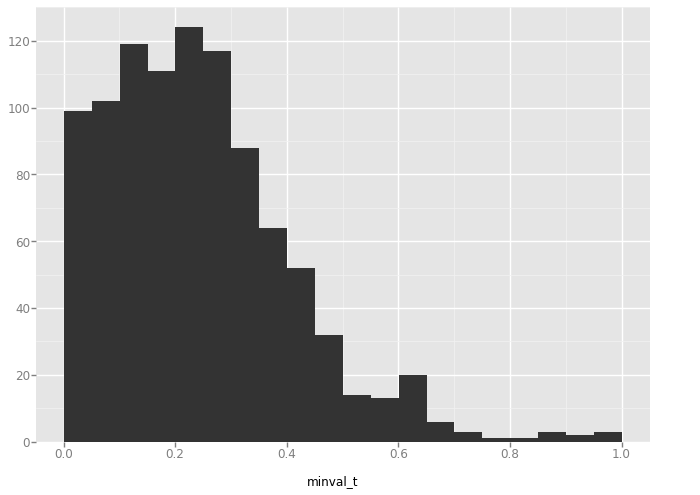

<ggplot: (287691447)>

In [40]:
p = ggplot(aes(x='minval_t'), data=test_df)
p + geom_histogram(binwidth=.05)


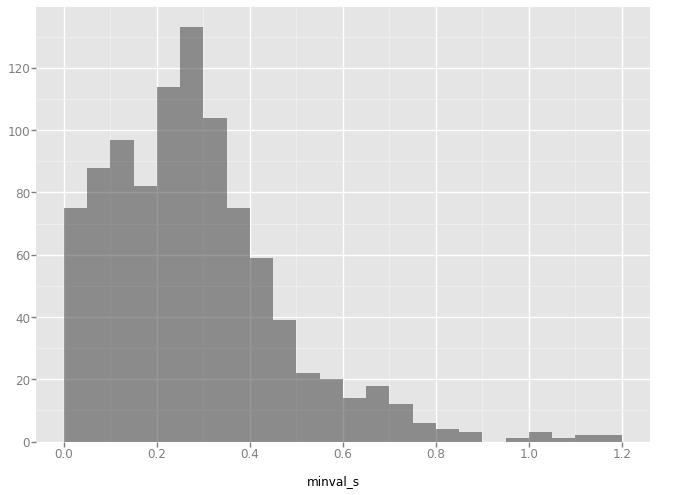

<ggplot: (-9223372036571315084)>

In [42]:
v = ggplot(aes(x='minval_s'), data=test_df)
v + geom_histogram(binwidth=.05,alpha=.5) 

In [ ]:
df